# AlexNet Implementation

## Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alexnetcifar/pytorch/firsttry/2/dataLoaderHelper.py
/kaggle/input/alexnetcifar/pytorch/firsttry/2/trainerHelper.py
/kaggle/input/alexnetcifar/pytorch/firsttry/2/baseSetterHelper.py
/kaggle/input/alexnetcifar/pytorch/firsttry/2/plottingHelper.py
/kaggle/input/alexnetcifar/pytorch/firsttry/1/dataLoaderHelper.py
/kaggle/input/alexnetcifar/pytorch/firsttry/1/trainerHelper.py
/kaggle/input/alexnetcifar/pytorch/firsttry/1/baseSetterHelper.py
/kaggle/input/alexnetcifar/pytorch/firsttry/1/plottingHelper.py


In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as F

In [3]:
import sys
sys.path.insert(0, '/kaggle/input/alexnetcifar/pytorch/firsttry/2/')
from baseSetterHelper import setAllSeeds, setDeterministic, computeAccu, computeConfusionMatrix
from trainerHelper import modelTrainer
from plottingHelper import plotTrainingLoss, plotAccuracy, show_examples, plotConfusionMat
from dataLoaderHelper import getDataLoadersCIFAR10, UnNormalize

## Settings and DataSet with DataLoader Handling

In [4]:
##########
##Settings
##########

numEpochs = 250
batchSize = 256
randomSeed = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [5]:
setAllSeeds(randomSeed)

In [6]:
trainTransforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70,70)),
    torchvision.transforms.RandomCrop((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [7]:
testTransforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70,70)),
    torchvision.transforms.CenterCrop((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [8]:
trainLoader, valLoader, testLoader = getDataLoadersCIFAR10(batchSize=batchSize, validFraction=0.1, trainTransforms=trainTransforms, testTransforms=testTransforms)


100%|██████████| 170498071/170498071 [00:02<00:00, 70433005.26it/s]


Extracting data/cifar-10-python.tar.gz to data


In [9]:
trainLoader

In [10]:
for images, labels in trainLoader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


## AlexNet Class

In [11]:
class alexNet(F.Module):
  def __init__(self,numClasses):
    super().__init__()
    self.numClasses = numClasses
    self.Conv = F.Sequential(
        #
        F.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
        F.ReLU(),
        F.MaxPool2d(kernel_size=3,stride=2),
        #
        F.Conv2d(64,192,kernel_size=5,padding=2),
        F.ReLU(),
        F.MaxPool2d(kernel_size=3,stride=2),
        #
        F.Conv2d(192,384,kernel_size=3,padding=1),
        F.ReLU(),
        #
        F.Conv2d(384,256,kernel_size=3,padding=1),
        F.ReLU(),
        #
        F.Conv2d(256,256,kernel_size=3,padding=1),
        F.ReLU(),
        F.MaxPool2d(kernel_size=3,stride=2)
    )
    self.AdaptPool = F.AdaptiveAvgPool2d((6,6))
    self.Classifier = F.Sequential(
        #
        F.Dropout(0.5),
        F.Linear(256*6*6,4096),
        F.ReLU(),
        #
        F.Dropout(0.5),
        F.Linear(4096,4096),
        F.ReLU(),
        #
        F.Linear(4096,numClasses),
        F.ReLU()
    )

  def forward(self,x):
    x = self.Conv(x)
    x = self.AdaptPool(x)
    x = x.view(x.size(0), 256 * 6 * 6)
    logits = self.Classifier(x)
    return logits

## Initialization

In [12]:
model = alexNet(numClasses=10)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9,lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

In [13]:
miniBatchLossList, trainAccList, validAccList = modelTrainer(
    model1=model,
    numEpochs=numEpochs,
    trainLoader=trainLoader,
    valLoader=valLoader,
    testLoader=testLoader,
    opt=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    schedulerOn='validAcc')

Epoch:001/250 | Batch:000/175 |  Cost:2.3029
Epoch:001/250 | Batch:050/175 |  Cost:2.2428
Epoch:001/250 | Batch:100/175 |  Cost:2.1592
Epoch:001/250 | Batch:150/175 |  Cost:2.1150
Epoch:001/250 |
Train Acc 19.6339%
Val Acc   20.2800%
Time Taken: 1.01 min
Epoch:002/250 | Batch:000/175 |  Cost:2.1203
Epoch:002/250 | Batch:050/175 |  Cost:2.0553
Epoch:002/250 | Batch:100/175 |  Cost:2.0149
Epoch:002/250 | Batch:150/175 |  Cost:1.9262
Epoch:002/250 |
Train Acc 29.7143%
Val Acc   30.6000%
Time Taken: 1.98 min
Epoch:003/250 | Batch:000/175 |  Cost:1.9773
Epoch:003/250 | Batch:050/175 |  Cost:2.1222
Epoch:003/250 | Batch:100/175 |  Cost:1.8325
Epoch:003/250 | Batch:150/175 |  Cost:1.9761
Epoch:003/250 |
Train Acc 30.5938%
Val Acc   30.2400%
Time Taken: 2.94 min
Epoch:004/250 | Batch:000/175 |  Cost:1.8424
Epoch:004/250 | Batch:050/175 |  Cost:1.5575
Epoch:004/250 | Batch:100/175 |  Cost:1.8302
Epoch:004/250 | Batch:150/175 |  Cost:1.7385
Epoch:004/250 |
Train Acc 43.2679%
Val Acc   44.0200%
T

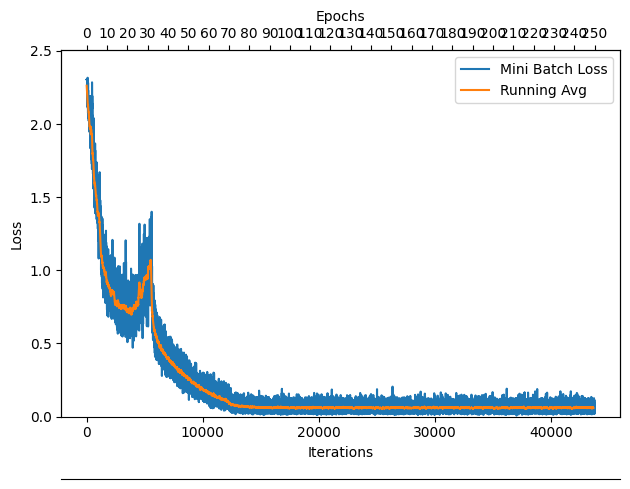

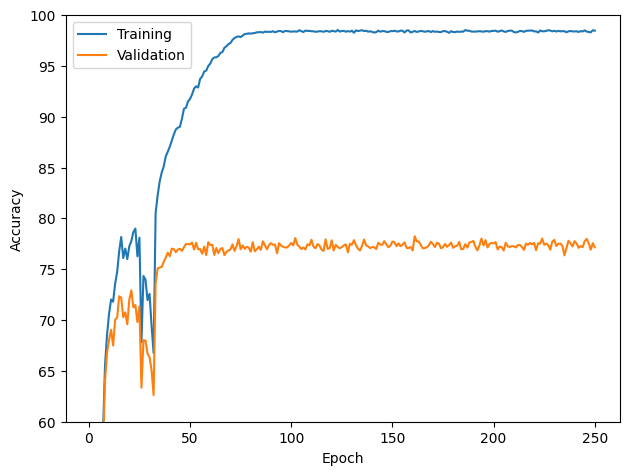

In [14]:
plotTrainingLoss(miniBatchLoss=miniBatchLossList,
                   numEpoch=numEpochs,
                   iterPerEpoch=len(trainLoader),
                   resultsDir=None,
                   avgIter=100)    #plotTrainingLoss(miniBatchLoss,numEpoch,iterPerEpoch,resultsDir=None,avgIter = 100)
plt.show()
plotAccuracy(trainAccList,validAccList)
plt.ylim([60,100])
plt.show()

## Saving Model

In [15]:
torch.save(model.state_dict(), 'model.pt')
torch.save(optimizer.state_dict(), 'optimizer.pt')
torch.save(scheduler.state_dict(), 'scheduler.pt')